<a href="https://colab.research.google.com/github/jiayuzhao05/Deep-learning/blob/main/Pytorch/Tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial4: Convolutional Layers - Spectral methods

## Outline

- Why convolution in ML
- Some theory on convolution
- Convolution on graphs
- Spectral-convolutional layers in PyTorch Geometric

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 34.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

## Why convolution in ML

- Weight sharing
- Detection of translational invariant and local features

![](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/fully_connected.png?raw=1)
[Source](https://missinglink.ai/guides/convolutional-neural-networks/fully-connected-layers-convolutional-neural-networks-complete-guide/)

![](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/cnn.gif?raw=1)
[Source](https://commons.wikimedia.org/wiki/File:Convolutional_Neural_Network.gif)

![](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/Convolution.png?raw=1)
[Source](https://commons.wikimedia.org/wiki/File:Convolution.PNG)

## Some theory on convolution

![](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/Convolution_of_box_signal_with_itself2.gif?raw=1)
[Source](https://en.wikipedia.org/wiki/File:Convolution_of_box_signal_with_itself2.gif)

### Definition

\begin{align*}
c[n] = (v * w)[n] = \sum_{m=0}^{N-1} v[m] \cdot w[n-m]
\end{align*}

In [3]:
def conv(v, w):
    c = np.zeros(v.shape)
    for n in range(len(v)):
        c[n] = 0
        for m in range(len(v)):
            c[n] += v[m] * w[n - m]
    return c

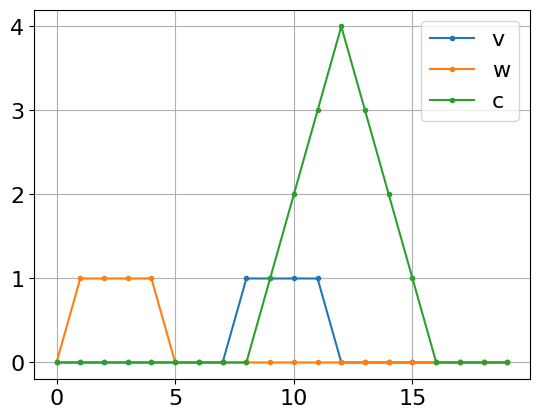

In [4]:
N = 20
v = np.zeros(N)
v[8:12] = 1
w = np.zeros(N)
w[1:5] = 1
c = conv(v, w)

fig = plt.figure()
ax = fig.gca()
ax.plot(v, '.-')
ax.plot(w, '.-')
ax.plot(c, '.-')
ax.legend(['v', 'w', 'c'])
ax.grid(True)

### Fourier transform

Transformation $\mathcal F: \mathbb{R}^N \to \mathbb{R}^N$ with

\begin{align*}
\mathcal F^{-1}(\mathcal F (v)) &= v\\
\mathcal F(v * w) &= \mathcal F(v) \cdot \mathcal F(w).
\end{align*}

This implies
\begin{align*}
v * w &= \mathcal F^{-1}(\mathcal F (v * w))\\
&= \mathcal F^{-1}(\mathcal F(v) \cdot \mathcal F(w))
\end{align*}

In [5]:
v, w = np.random.rand(N), np.random.rand(N)
conv(v, w)

array([4.56533912, 3.5323014 , 3.72352031, 4.09783471, 4.90800807,
       4.25948217, 3.56173536, 3.82990645, 4.27839544, 4.80033232,
       4.02566581, 4.35688061, 4.29030464, 4.25853061, 4.91470851,
       4.32416003, 4.2238044 , 3.80442586, 3.71073042, 4.69027234])

In [6]:
from scipy.fft import fft, ifft # Fast Fourier Transform / Inverse FFT
np.abs(ifft(fft(v) * fft(w)))

array([4.56533912, 3.5323014 , 3.72352031, 4.09783471, 4.90800807,
       4.25948217, 3.56173536, 3.82990645, 4.27839544, 4.80033232,
       4.02566581, 4.35688061, 4.29030464, 4.25853061, 4.91470851,
       4.32416003, 4.2238044 , 3.80442586, 3.71073042, 4.69027234])

### Definition of the Fourier transform

The Fourier transform can be computed as

\begin{align*}
\mathcal F(v) = U\cdot v, \;\;\mathcal F^{-1}(v) = \frac{1}{N}\ U^H \cdot v
\end{align*}

where the $N\times N$ matrix $U$ is defined as
\begin{align*}
\\
U =
\begin{bmatrix}
u_0(0) & u_1(0) & \dots & u_{N-1}(0)\\
u_0(1) & u_1(1) & \dots & u_{N-1}(1)\\
\vdots & \vdots& & \vdots\\
u_0(N-1) & u_1(N-1) & \dots & u_{N-1}(N-1)\\
\end{bmatrix}
\end{align*}

and $u_0, \dots, u_{N-1}$ are functions defined as

\begin{align*}
u_n(x)&:= \cos\left(2 \pi \frac{n}{N} x\right) - i \sin\left(2 \pi \frac{n}{N} x\right).
\end{align*}

In [7]:
def matrix_U(N):
    u = lambda n, N: np.cos(2 * np.pi / N * n * np.arange(N)) - 1j * np.sin(2 * np.pi / N * n * np.arange(N))
    U = np.empty((N, 0))
    for n in range(N):
        U = np.c_[U, u(n, N)]
    return U


def fourier_transform(v):
    N = v.shape[0]
    U = matrix_U(N)
    return U @ v


def inverse_fourier_transform(v):
    N = v.shape[0]
    U = matrix_U(N)
    return (U.conj().transpose() @ v) / N

In [8]:
fft(v) - fourier_transform(v)

array([ 0.00000000e+00-0.00000000e+00j,  2.22044605e-16-2.22044605e-16j,
        4.44089210e-16-2.22044605e-16j, -4.99600361e-16+5.82867088e-16j,
        1.49880108e-15+0.00000000e+00j,  4.44089210e-15+1.33226763e-15j,
       -2.27595720e-15-1.11022302e-15j, -2.66453526e-15+1.38777878e-15j,
        0.00000000e+00+2.44249065e-15j, -3.33066907e-15+6.21724894e-15j,
        0.00000000e+00+1.19387108e-15j, -1.33226763e-15-7.77156117e-16j,
        2.66453526e-15-3.27515792e-15j, -6.66133815e-15-3.33066907e-15j,
       -2.38697950e-15-1.88737914e-15j,  4.44089210e-16+3.55271368e-15j,
       -6.66133815e-15+4.44089210e-16j, -1.33226763e-15-1.33920652e-14j,
        1.44328993e-15+3.10862447e-15j, -4.99600361e-15+2.66453526e-15j])

In [9]:
ifft(v) - inverse_fourier_transform(v)

array([ 0.00000000e+00-0.00000000e+00j,  1.73472348e-17-2.77555756e-17j,
        1.69135539e-17+2.08166817e-17j, -1.73472348e-17-1.73472348e-17j,
        7.28583860e-17+0.00000000e+00j,  2.15105711e-16-5.55111512e-17j,
       -1.11022302e-16+6.24500451e-17j, -1.45716772e-16-8.67361738e-17j,
        0.00000000e+00-1.05818132e-16j, -1.52655666e-16-3.03576608e-16j,
       -1.21430643e-17-5.96935539e-17j, -6.24500451e-17+4.16333634e-17j,
        1.24900090e-16+1.56125113e-16j, -3.53883589e-16+1.59594560e-16j,
       -1.17961196e-16+8.67361738e-17j,  2.08166817e-17-1.76941795e-16j,
       -3.46944695e-16-4.16333634e-17j, -5.55111512e-17+6.49653942e-16j,
        9.45424294e-17-1.52655666e-16j, -2.39391840e-16-1.94289029e-16j])

### Connection with the Laplacian

The functions $u_n$ (the columns of the Fourier transform matrix) are eigenvectors of the Laplacian:

\begin{align*}
u_n(x)&:= \cos\left(2 \pi \frac{n}{N} x\right) - i \sin\left(2 \pi \frac{n}{N} x\right)\\
\Delta u_n(x)&:= \left(-4 \pi ^ 2\frac{n^2}{N^2}\right) u_n(x)
\end{align*}

### Summary

\begin{align*}
v * w
= U^H ((U  w) \odot (U  v))
\end{align*}

or if $g_w=\mbox{diag}(U w)$ is  filter
\begin{align*}
v * w
= U^H g_w U  w
\end{align*}

In [10]:
U = matrix_U(N)
np.abs((U.conj().transpose() / N) @ ((U @ v) * (U @ w)))

array([4.56533912, 3.5323014 , 3.72352031, 4.09783471, 4.90800807,
       4.25948217, 3.56173536, 3.82990645, 4.27839544, 4.80033232,
       4.02566581, 4.35688061, 4.29030464, 4.25853061, 4.91470851,
       4.32416003, 4.2238044 , 3.80442586, 3.71073042, 4.69027234])

In [11]:
conv(v, w)

array([4.56533912, 3.5323014 , 3.72352031, 4.09783471, 4.90800807,
       4.25948217, 3.56173536, 3.82990645, 4.27839544, 4.80033232,
       4.02566581, 4.35688061, 4.29030464, 4.25853061, 4.91470851,
       4.32416003, 4.2238044 , 3.80442586, 3.71073042, 4.69027234])

## Convolution on graphs

**Plan**:
    - Define the graph Laplacian
    - Compute the spectrum
    - Define a Fourier transform
    - Define convolution on a graph

**Note:** From now on $G = (V, E)$ is an undirected, unweighted, simple graph.

### Graph Laplacian

Adjacency matrix
\begin{align*}
A_{ij} = \left\{
    \begin{array}{ll}
    1 &\text{ if } e_{ij}\in E\\
    0 &\text{ if } e_{ij}\notin E
    \end{array}
    \right.
\end{align*}

Degree matrix
\begin{align*}
D_{ij} = \left\{
    \begin{array}{ll}
    \mbox{deg}(v_i) &\text{ if } i=j\\
    0 &\text{ if } i\neq j
    \end{array}
    \right.
\end{align*}

Laplacian
\begin{align*}
L &= D - A.
\end{align*}

Normalized Laplacian
\begin{align*}
L &= I - D^{-1/2} A D^{-1/2}.
\end{align*}

### Graph spectrum, Fourier transform, and convolution

1. Spectral decomposition of the Laplacian:
\begin{align*}
L = U \Lambda U^T\\
\end{align*}


2. Fourier transform: if $v$ is a vector of features on the graph, then
\begin{align*}
\mathcal F (v) = U \cdot v, \;\;\mathcal F^{-1} (v) = U^T \cdot v\\
\end{align*}


3. Convolution with a filter $U \cdot w$
\begin{align*}
v * w = U ((U^T  w) \odot (U^T  v) )
\end{align*}


Or $g_w = \mbox{diag}(U^T w)$ is a filter, then
\begin{align*}
v * w = U g_w U^T  v
\end{align*}


## Spectral-convolutional layers in PyTorch Geometric

**Problem:** Computing the spectrum is a global and very expensive property.

**Goal:** Implementation as message passing.

### ChebConv

- Original [paper](https://arxiv.org/pdf/1606.09375.pdf)
- PyTorch [doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.ChebConv)

#### Goal:
Compute $U g_w U^T x$ with $g_w = g_w(\Lambda)$ a filter.

#### Chebyshev approximation

Chebyshev polynomials $T_k$:
\begin{align*}
T_{k}(x) = 2 x T_{k-1}(x) - T_{k-2}(x), \;\; T_0(x) = 1, T_1(x) = x
\end{align*}

#### Chebyshev approximation of the filter
Aproximation of the filter:
\begin{align*}
g_w(\Lambda) = \sum_{k=0}^K \theta_k T_k(\tilde \Lambda),\;\;\;\;\tilde \Lambda = \frac{2}{\lambda_\max} \Lambda - I
\end{align*}


#### Property
If $L = U \Lambda U^T$ then $T_k(L) = U T_k(\Lambda) U^T$.


#### Fast approximated convolution
\begin{align*}
v * w &= U g_w U^T x
= U \left(\sum_{k=0}^K \theta_k T_k(\tilde \Lambda) \right)U^T x
=\sum_{k=0}^K  \theta_k U  T_k(\tilde \Lambda) U^T x\\
&=\sum_{k=0}^K  \theta_k T_k(\tilde L) x
\end{align*}

\begin{align*}
\tilde L = \frac{2}{\lambda_\max} L - I
\end{align*}

#### Properties:
- Depends on $L$ and $\lambda_\max$, not on $U, \Sigma$
- Uses only $K$-powers $\Rightarrow$ only the $K$-th neighborhood of each node, localized filter

**As message passing:**
![](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/cheb_init.png?raw=1)

![](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/cheb_norm.png?raw=1)

![](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/cheb_forward.png?raw=1)

![](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/cheb_message.png?raw=1)

### GCNConv

- Original [paper](https://arxiv.org/pdf/1609.02907.pdf)
- PyTorch [doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)

Start from `ChebConv` and assume
1. $K=1$ (linear approximation) so
\begin{align*}
v * w
&=\sum_{k=0}^1  \theta_k T_k(\tilde L) x
= \theta_0 x + \theta_1 \tilde L x\\
\end{align*}

2. $\lambda_\max =2$ so
\begin{align*}
v * w
&= \theta_0 x + \theta_1 (L - I) x\\
&= \theta_0 x - \theta_1 D^{-1/2} A D^{1/2} x\\
\end{align*}


3. $\theta_0=-\theta_1= \theta$ so
\begin{align*}
v * w = \left(I + D^{-1/2} A D^{1/2}\right) x \theta
\end{align*}

4. Renormalization of $\theta$ by using
\begin{align*}
\tilde A&:= I + A\\
\tilde D_{ii}&:= \sum_j \tilde A_{ij}
\end{align*}
so
\begin{align*}
v * w = \left(D^{-1/2} A D^{1/2}\right) x \theta
\end{align*}

If $x$ is a $F$-dimensional feature vector, and we want an $F'$-dimensional feature vector as output:
use $W'\in \mathbb{R}^{F\times F'}$
\begin{align*}
v * w = \left(D^{-1/2} A D^{1/2}\right) x \Theta
\end{align*}


Nodewise:
    ![image.png](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/gcn_nodewise.png?raw=1)

#### As message passing
See Tutorial3